In [26]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import os
import seaborn as sns

 Dataset link : https://www.thedatum.org/datasets/TSB-UAD-Public.zip

# Dodgers Dataset

In [3]:
folder_path = "../Data/TSB_UAD/TSB-UAD-Public/Dodgers"


df = pd.read_csv(os.path.join(folder_path, "101-freeway-traffic.test.out"), delimiter=',', header=None, names=['value', 'is_anomaly'])
df.head()

,value,is_anomaly
0,-1,1
1,-1,1
2,-1,1
3,-1,1
4,-1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50400 entries, 0 to 50399
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   value       50400 non-null  int64
 1   is_anomaly  50400 non-null  int64
dtypes: int64(2)
memory usage: 787.6 KB


In [5]:
df['is_anomaly'].value_counts()

is_anomaly
0    44788
1     5612
Name: count, dtype: int64

In [6]:
df = df[df['value'] != -1].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47497 entries, 0 to 47496
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   value       47497 non-null  int64
 1   is_anomaly  47497 non-null  int64
dtypes: int64(2)
memory usage: 742.3 KB


In [7]:
df['is_anomaly'].value_counts()

is_anomaly
0    44788
1     2709
Name: count, dtype: int64

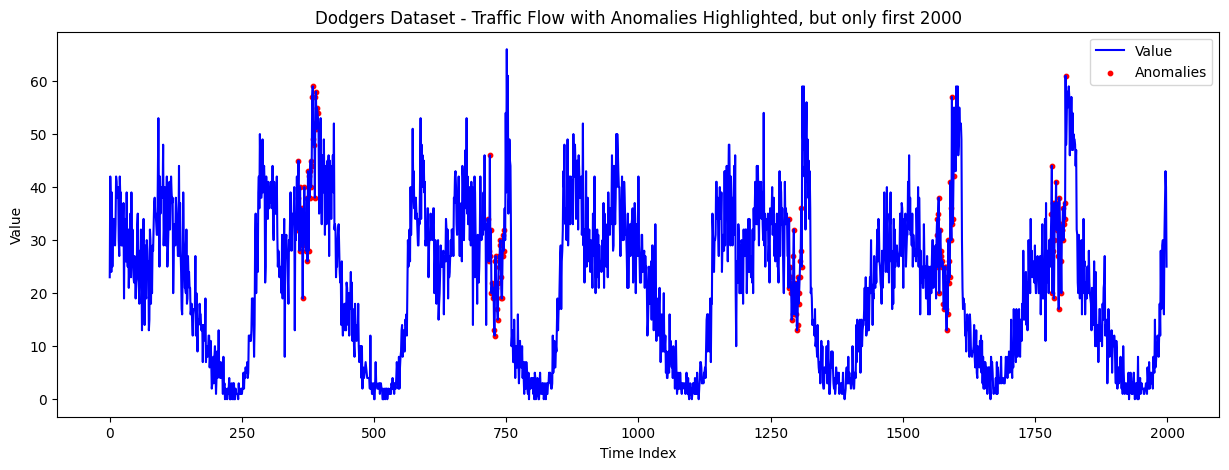

In [8]:
time_window = 2000
df_subset = df.iloc[:time_window]

plt.figure(figsize=(15, 5))
plt.plot(df_subset['value'], color='blue', label='Value')
anomalous_points = df_subset[df_subset['is_anomaly'] == 1]
plt.scatter(anomalous_points.index, anomalous_points['value'], color='red', s=10, label='Anomalies')

plt.xlabel('Time Index')
plt.ylabel('Value')
plt.title(f'Dodgers Dataset - Traffic Flow with Anomalies Highlighted, but only first {time_window}')
plt.legend()
plt.show()


In [9]:
# Parameters for sliding window
window_size = 200  # Length of each sub-sequence
stride = 100  # How much to shift the window by

# Extract sub-sequences
sequences = []
labels = []

for i in range(0, len(df) - window_size + 1, stride):
    sub_sequence = df.iloc[i:i + window_size]
    value_sequence = sub_sequence['value'].values  # Extract the value column
    anomaly_flag = int(sub_sequence['is_anomaly'].max() == 1)  # Check if any 'is_anomaly' in the window is 1
    sequences.append(value_sequence)
    labels.append(anomaly_flag)

# Print some information about the sequences
print(f"Total sequences extracted: {len(sequences)}")
print(f"Label counts (0 = normal, 1 = anomalous): {np.unique(labels, return_counts=True)}")


Total sequences extracted: 473
Label counts (0 = normal, 1 = anomalous): (array([0, 1]), array([300, 173]))


In [10]:
def plot_sequences_with_labels(sequences, labels, num_sequences=5):
    plt.figure(figsize=(15, num_sequences * 3))
    
    for i in range(min(num_sequences, len(sequences))):
        plt.subplot(num_sequences, 1, i + 1)
        plt.plot(sequences[i], label=f'Sequence {i+1} ({ "Anomalous" if labels[i] == 1 else "Normal" })', 
                 color='red' if labels[i] == 1 else 'blue')
        plt.title(f'Sub-Sequence {i+1} - {"Anomalous" if labels[i] == 1 else "Normal"}')
        plt.xlabel('Time Index')
        plt.ylabel('Value')
        plt.legend(loc='upper right')
        
    plt.tight_layout()
    plt.show()

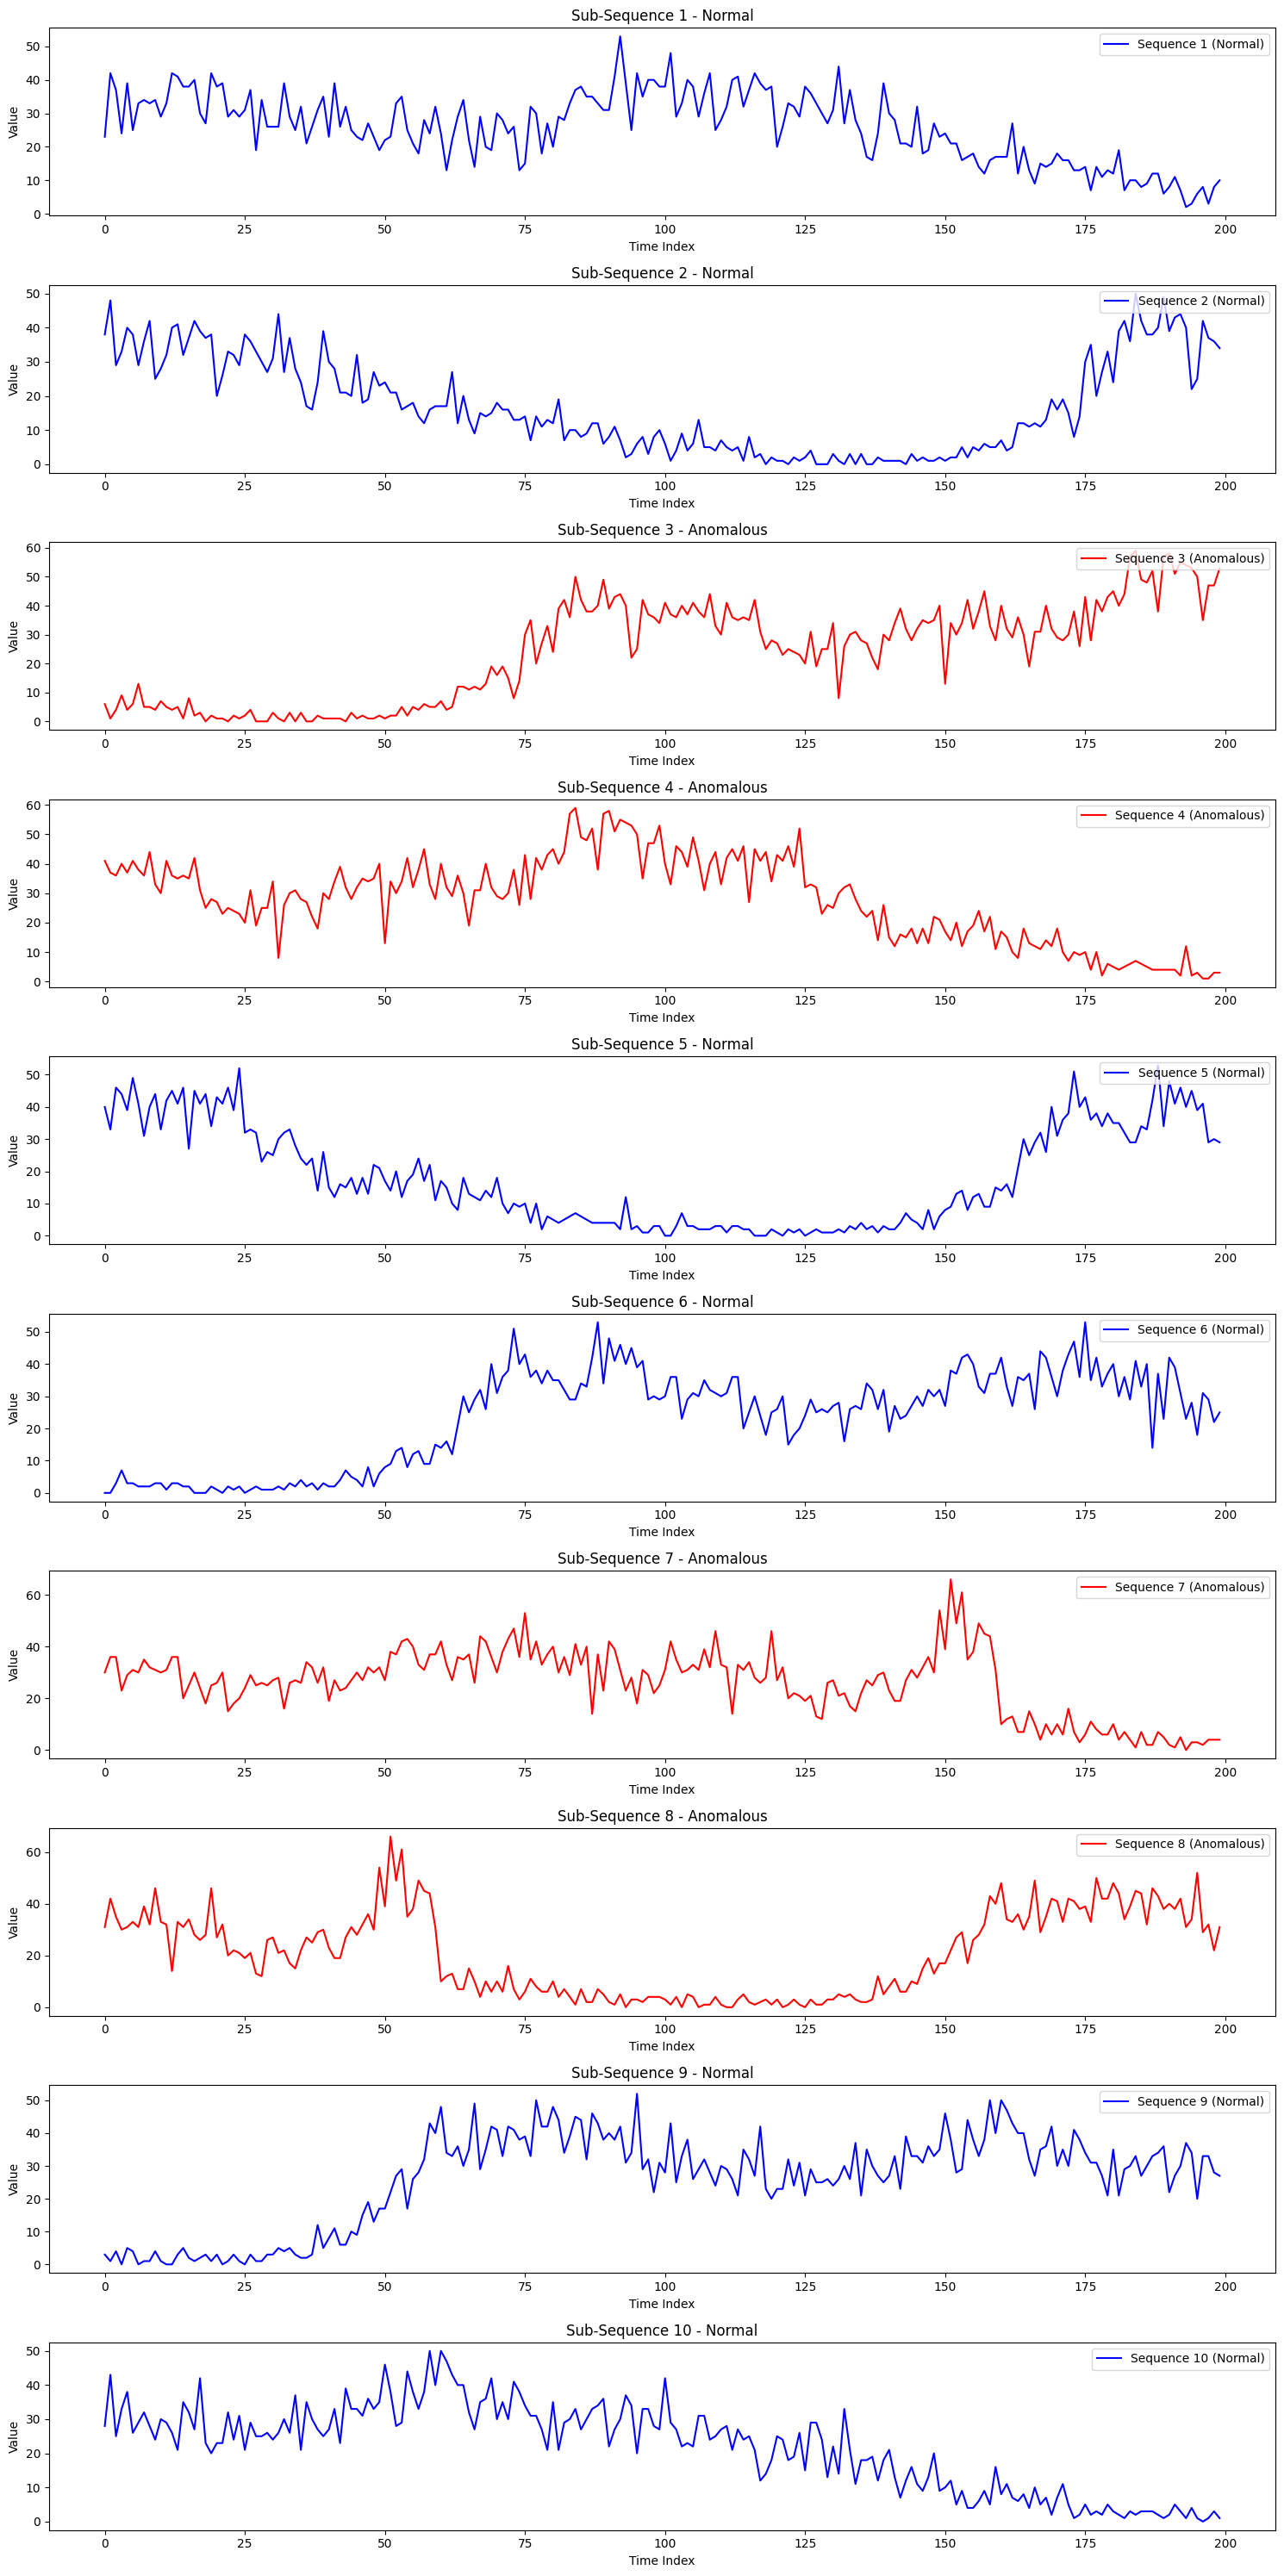

In [11]:
plot_sequences_with_labels(sequences, labels, 10)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

class SAX:
    def __init__(self, word_size=10, alphabet_size=7, mode="global"):
        self.word_size = word_size
        self.alphabet_size = alphabet_size
        self.alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"[:alphabet_size]
        self.mode = mode
        self.breakpoints = self._compute_breakpoints(alphabet_size)
        self.symbol_mapping = self._compute_symbol_mapping()
        
    def _compute_breakpoints(self, alphabet_size):
        quantiles = [(i / alphabet_size) for i in range(1, alphabet_size)]
        breakpoints = norm.ppf(quantiles)
        return breakpoints

    def _compute_symbol_mapping(self):
        symbol_mapping = {}
        mids = []
        for point1, point2 in zip([-np.inf] + list(self.breakpoints), list(self.breakpoints) + [np.inf]):
            mids.append((point1 + point2) / 2)
        for i, mid in enumerate(mids):
            symbol_mapping[self.alphabet[i]] = mid
        return symbol_mapping

    def _z_normalize(self, sequence):
        if self.mode == "global":
            return (np.array(sequence) - np.mean(sequence)) / (np.std(sequence) + 1e-12)
        elif self.mode == "local":
            return (np.array(sequence) - sequence.mean()) / (sequence.std() + 1e-12)
        else:
            raise ValueError("Please specify 'local' or 'global' mode")
    
    def _paa(self, sequence):
        n = len(sequence)
        paa_segment_size = n // self.word_size
        paa_values = [np.mean(sequence[i*paa_segment_size:(i+1)*paa_segment_size]) for i in range(self.word_size)]
        return np.array(paa_values)
    
    def _discretize(self, paa_values):
        symbols = []
        for val in paa_values:
            idx = np.sum(val > self.breakpoints) 
            symbols.append(self.alphabet[idx])
        return ''.join(symbols)
    
    def read_file(self, file_path):
        df = pd.read_csv(file_path, delimiter=',', header=None, names=['value', 'is_anomaly'])
        df_clean = df[df['value'] != -1].reset_index(drop=True)
        self.df = df_clean
        return self.df

    def transform(self, window_size=200, stride=100):
        self.sequences = []
        self.sax_sequences = []
        self.labels = []

        for i in range(0, len(self.df) - window_size + 1, stride):
            sub_sequence = self.df.iloc[i:i + window_size]
            value_sequence = sub_sequence['value'].values  # Extract the continuous values
            z_normed = self._z_normalize(value_sequence)
            paa_vals = self._paa(z_normed)
            sax_sequence = self._discretize(paa_vals)
            anomaly_flag = int(sub_sequence['is_anomaly'].max() == 1)
            
            self.sequences.append(value_sequence)
            self.sax_sequences.append(sax_sequence)
            self.labels.append(anomaly_flag)
        self.sax_sequences = list(self.sax_sequences)
        self.dataset = pd.DataFrame({
            'sax_sequence': list(self.sax_sequences),
            'original_sequence': self.sequences,
            'is_anomalous': self.labels
        })
        return self.dataset

    def display_sequence(self, sequence_number, figsize=(10, 5)):
        sax_sequence = self.dataset.iloc[sequence_number, 0] 
        timeserie = self.dataset.iloc[sequence_number, 1]
        label = self.dataset.iloc[sequence_number, 2]

        value_sequence = [self.symbol_mapping[symbol] for symbol in sax_sequence]
        segment_length = len(timeserie) // len(sax_sequence)  
        time_points = [i * segment_length for i in range(len(sax_sequence))]

        fig, ax = plt.subplots(figsize=figsize)
        ax.set_title(f"Sequence {sequence_number}, Label: {'Anomalous' if label == 1 else 'Normal'}", fontsize=14)
        ax.plot(timeserie, label="Continuous Time Series", color='blue')
        
        for i, value in enumerate(value_sequence):
            ax.hlines(value, time_points[i], time_points[i] + segment_length, colors='red', linewidth=2, label="Discretized SAX" if i == 0 else "")

        ax.set_xlabel("Time Index", fontsize=12)
        ax.set_ylabel("Value", fontsize=12)
        ax.legend()

        ax2 = ax.twinx()
        ax2.set_ylim(ax.get_ylim()) 
        ax2.set_yticks([self.symbol_mapping[letter] for letter in list(self.alphabet)])
        ax2.set_yticklabels(list(self.alphabet)) 
        ax2.set_ylabel("SAX Symbols", fontsize=12)
        
        plt.show()



In [13]:
sax = SAX(word_size=10, alphabet_size=7, mode="global")  # Set SAX parameters
df_clean = sax.read_file(os.path.join(folder_path, "101-freeway-traffic.test.out"))
print(f"Data loaded with {len(df_clean)} points.")

Data loaded with 47497 points.


In [14]:
df_results = sax.transform(window_size=200, stride=100)
df_results.head()

,sax_sequence,original_sequence,is_anomalous
0,FEDCFFECAA,"[23, 42, 37, 24, 39, 25, 33, 34, 33, 34, 29, 3...",0
1,GFECBBABDG,"[38, 48, 29, 33, 40, 38, 29, 36, 42, 25, 28, 3...",0
2,AAACFFDEEG,"[6, 1, 4, 9, 4, 6, 13, 5, 5, 4, 7, 5, 4, 5, 1,...",1
3,ECEEGFEBAA,"[41, 37, 36, 40, 37, 41, 38, 36, 44, 33, 30, 4...",1
4,GFDCBBABFG,"[40, 33, 46, 44, 39, 49, 41, 31, 40, 44, 33, 4...",0


In [15]:
baseline = df_results.loc[df_results["is_anomalous"] == 0]
anomaly = df_results.loc[df_results["is_anomalous"] == 1]

print(f"length category anomalous : {len(anomaly)} : length category normal : {len(baseline)}")

baseline_train = baseline.sample(frac=0.8, random_state=42)
baseline_validation = baseline.drop(baseline_train.index)
test_set = pd.concat([baseline_validation, anomaly])

baseline_validation = baseline_validation["sax_sequence"].values
baseline_train = baseline_train["sax_sequence"].values
test_labels = test_set['is_anomalous'].values
test_set = test_set["sax_sequence"].values

length category anomalous : 173 : length category normal : 300


In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
def plot_roc_curve(method, test_labels, test_proba):
    roc_auc = roc_auc_score(test_labels, test_proba)
    fpr, tpr, _ = roc_curve(test_labels, test_proba)
    plt.plot(fpr, tpr, label=f"{method}" + " (AUC = {:.2f})".format(roc_auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


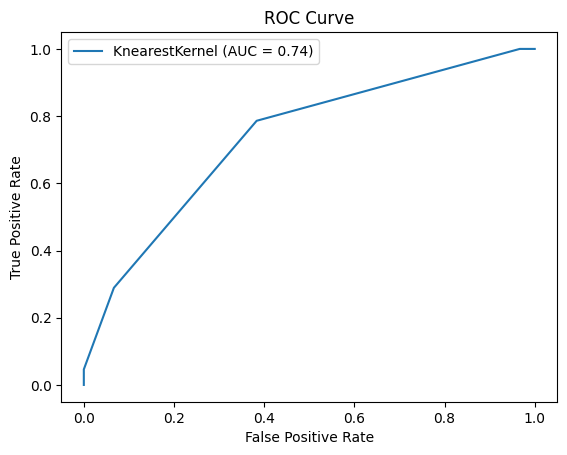

In [17]:
# try out the kernel methods
from KernelBased import KnearestKernel, MedoidsKernel, nLCS

knearest_dad = KnearestKernel(nLCS)
knearest_dad.train(baseline_train)

test_proba = knearest_dad.predict_proba(test_set)
plot_roc_curve("KnearestKernel", test_labels, test_proba)

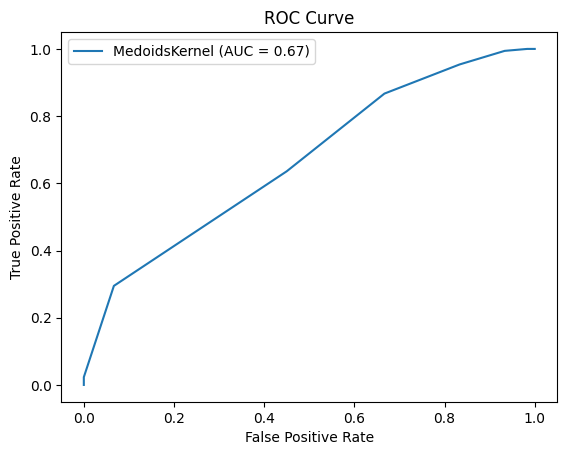

In [18]:
kmedoids_dad = MedoidsKernel(nLCS)
kmedoids_dad.train(baseline_train)

test_proba = kmedoids_dad.predict_proba(test_set)
plot_roc_curve("MedoidsKernel", test_labels, test_proba)

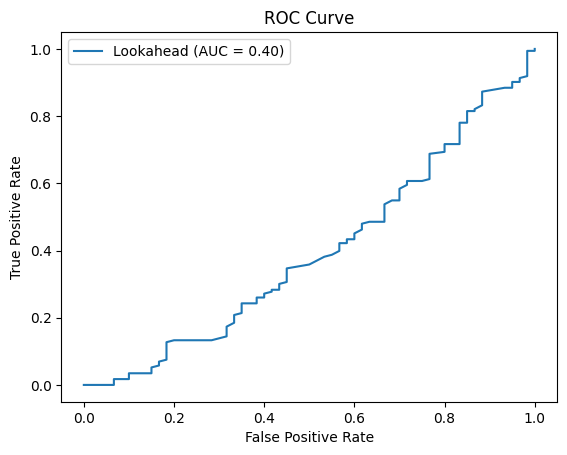

In [19]:
from WindowBased import Lookahead, NormalDictionary, UnsupervisedSVM

lookahead = Lookahead(window_length=10)
lookahead.train(baseline_train)

test_proba = lookahead.predict_proba(test_set)
plot_roc_curve("Lookahead", test_labels=test_labels, test_proba=test_proba)

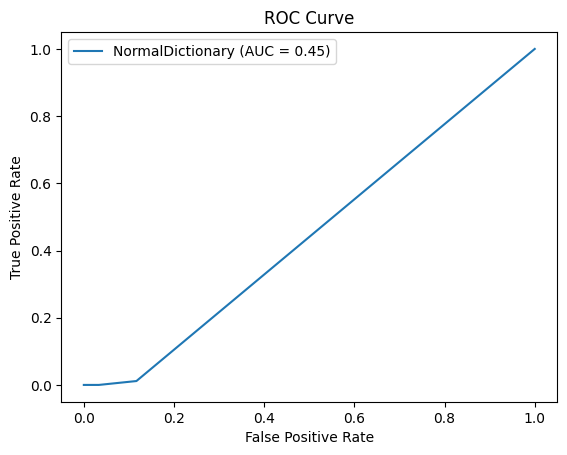

In [20]:
normal_dic = NormalDictionary(window_length=10)
normal_dic.train(baseline_train)

test_proba = normal_dic.predict_proba(test_set)

plot_roc_curve("NormalDictionary", test_labels=test_labels, test_proba=test_proba)

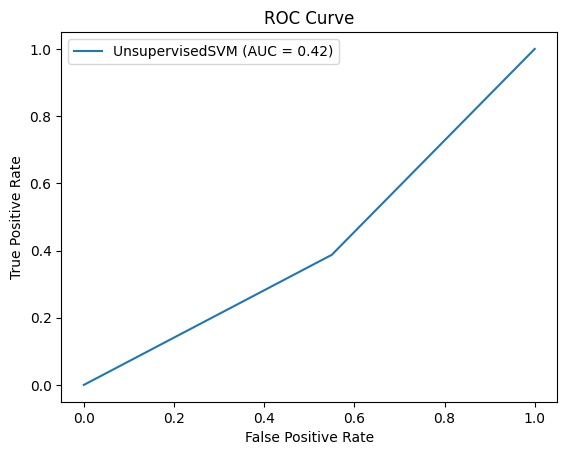

In [21]:
svm = UnsupervisedSVM(window_length=10)
svm.train(baseline_train)
test_proba = svm.predict_proba(test_set)
plot_roc_curve("UnsupervisedSVM", test_labels, test_proba)

# SAX parameters and  influence on results

In [22]:
alphabet_sizes = [3, 5, 7, 10]  # Possible alphabet sizes
word_sizes = [5, 10, 20, 50]    # Possible word sizes

results = []

for alphabet_size in alphabet_sizes:
    for word_size in word_sizes:
        print(f"📊 Running for Alphabet Size={alphabet_size}, Word Size={word_size}")
        
        # initialize and transform the dataset using SAX
        sax = SAX(word_size=word_size, alphabet_size=alphabet_size, mode="global")
        df_clean = sax.read_file(os.path.join(folder_path, "101-freeway-traffic.test.out"))
        df_results = sax.transform(window_size=200, stride=100)
        
        # split into normal and anomalous sequences
        baseline = df_results.loc[df_results["is_anomalous"] == 0]
        anomaly = df_results.loc[df_results["is_anomalous"] == 1]
        
        baseline_train = baseline.sample(frac=0.8, random_state=42)
        baseline_validation = baseline.drop(baseline_train.index)
        test_set = pd.concat([baseline_validation, anomaly])

        baseline_validation = baseline_validation["sax_sequence"].values
        baseline_train = baseline_train["sax_sequence"].values
        test_labels = test_set['is_anomalous'].values
        test_set = test_set["sax_sequence"].values        

        knearest_dad = KnearestKernel(nLCS)
        knearest_dad.train(baseline_train)
        
        # Step 4: Predict anomaly scores on the test set
        test_proba = knearest_dad.predict_proba(test_set)
        
        # Step 5: Calculate the ROC-AUC score
        try:
            roc_auc = roc_auc_score(test_labels, test_proba)
        except ValueError as e:
            print(f"Error calculating ROC-AUC for Alphabet Size={alphabet_size}, Word Size={word_size}: {e}")
            roc_auc = 0  # Set to 0 if ROC-AUC fails

        print(f"📈 ROC-AUC for Alphabet Size={alphabet_size}, Word Size={word_size}: {roc_auc:.4f}")
        
        # Store the results
        results.append({
            'alphabet_size': alphabet_size,
            'word_size': word_size,
            'roc_auc': roc_auc
        })

# 6️⃣ Create a DataFrame to store all results
df_performance = pd.DataFrame(results)


📊 Running for Alphabet Size=3, Word Size=5
📈 ROC-AUC for Alphabet Size=3, Word Size=5: 0.6118
📊 Running for Alphabet Size=3, Word Size=10
📈 ROC-AUC for Alphabet Size=3, Word Size=10: 0.6475
📊 Running for Alphabet Size=3, Word Size=20
📈 ROC-AUC for Alphabet Size=3, Word Size=20: 0.7027
📊 Running for Alphabet Size=3, Word Size=50
📈 ROC-AUC for Alphabet Size=3, Word Size=50: 0.6881
📊 Running for Alphabet Size=5, Word Size=5
📈 ROC-AUC for Alphabet Size=5, Word Size=5: 0.6329
📊 Running for Alphabet Size=5, Word Size=10
📈 ROC-AUC for Alphabet Size=5, Word Size=10: 0.6719
📊 Running for Alphabet Size=5, Word Size=20
📈 ROC-AUC for Alphabet Size=5, Word Size=20: 0.6899
📊 Running for Alphabet Size=5, Word Size=50
📈 ROC-AUC for Alphabet Size=5, Word Size=50: 0.6895
📊 Running for Alphabet Size=7, Word Size=5
📈 ROC-AUC for Alphabet Size=7, Word Size=5: 0.6562
📊 Running for Alphabet Size=7, Word Size=10
📈 ROC-AUC for Alphabet Size=7, Word Size=10: 0.7357
📊 Running for Alphabet Size=7, Word Size=20
📈 

In [23]:
df_performance = df

,alphabet_size,word_size,roc_auc
0,3,5,0.611753
1,3,10,0.647495
2,3,20,0.702746
3,3,50,0.688054
4,5,5,0.632900
5,5,10,0.671869
6,5,20,0.689933
7,5,50,0.689547
8,7,5,0.656166
9,7,10,0.735694


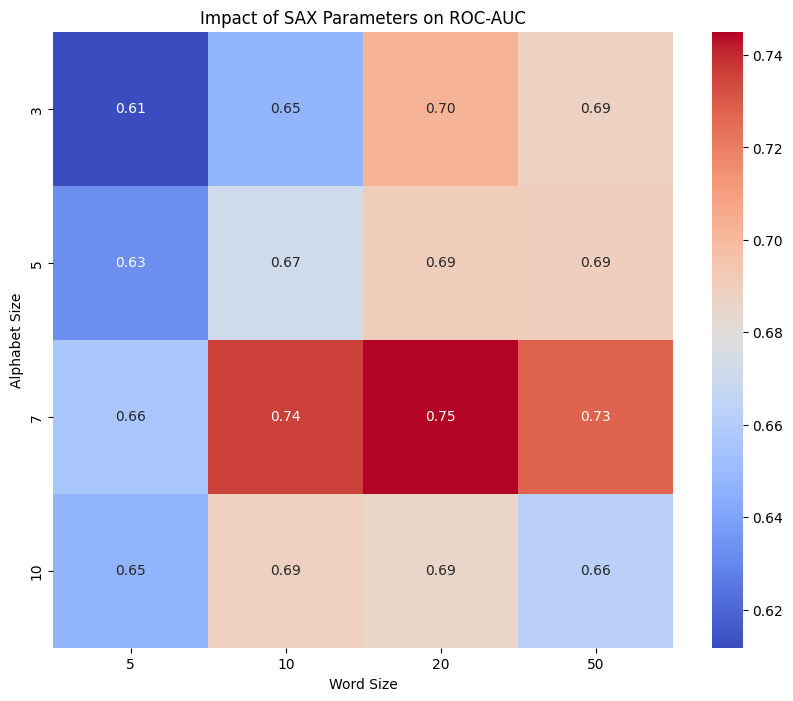

In [27]:
pivot = df_performance.pivot(index='alphabet_size', columns='word_size', values='roc_auc')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Impact of SAX Parameters on ROC-AUC')
plt.xlabel('Word Size')
plt.ylabel('Alphabet Size')
plt.show()


- Impact of Alphabet Size:

**Increasing** the alphabet size **improves** the model's ability to distinguish finer variations in the data.
For smaller alphabet sizes (e.g., 3), the discretization is too coarse, leading to **information loss** and reduced ROC-AUC scores.
At an alphabet size of 7, the model captures a **good balance between granularity and generalization**, which maximizes performance.

- Impact of Word Size:

**Smaller** word sizes (e.g., 5) summarize the time series into very few segments, which **oversimplifies** the data and reduces the model's accuracy.
**Larger** word sizes (e.g., 20) divide the sequence into more segments, preserving temporal details while still benefiting from discretization.
However, **extremely large** word sizes (50) may start introducing **noise or redundancy**, as seen in the slight drop in performance at word size = 50.
